<title> General </title>
<h1> General Control system </h1>
<h2> Libraries </h2>

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
import scipy.optimize as opt
import random

<h2> Heat exchanger with bypass </h2>
<img src = "System Schematic.png" width = "400px"></img>
<h3> Physical Components </h3>

In [3]:
# Fluid for each stage
class Fluid:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Splits the stream into two parts: Heat X and bypass. Assumed directly proportional to valve opening
class Tee:
    def __init__(self, fluid, pipe_ratio = 0.1):
        self.pipe_ratio = pipe_ratio
        self.valve = Valve()
        self.flow_ratio = pipe_ratio * self.valve.pos
        self.fluid = copy.copy(fluid)

    def split(self):
        fluid = self.fluid
        self.flow_ratio = self.pipe_ratio * self.valve.pos
        m1 = (1-self.flow_ratio) * fluid.m
        m2 = self.flow_ratio * fluid.m
        self.next[0].fluid = copy.copy(fluid)
        self.next[0].fluid.m = m1
        self.next[1].fluid[1] = copy.copy(fluid)
        self.next[1].fluid[1].m = m2

class Valve:
    def __init__(self, position = 0):
        self.pos = position

# Heat exchanger (maths is hopefully right)
class HeatX:
    def __init__(self, **kwargs):
        self.UA = 100e3 if "UA" not in kwargs else kwargs["UA"]
        self.Ts = 100 if "Ts" not in kwargs else kwargs["Ts"]

    def T_out(self, **kwargs):
        fluid = self.fluid
        T0 = fluid.T
        m1 = fluid.m
        Tf = math.exp(-self.UA/(m1*fluid.Cp))*(T0 - self.Ts) + self.Ts
        self.next.fluid[0] = copy.copy(fluid)
        self.next.fluid[0].T = Tf

# Mixes the stream back up. Assumes same heat capacity etc.
class Mixer:
    def __init__(self, **kwargs):
        self.fluid = ['','']

    def T_out(self):
        fluid     = self.fluid
        Tm        = sum([f.T*f.m for f in fluid])
        fl        = copy.copy(fluid[0])
        fl.m      = sum([f.m for f in fluid])
        fl.T      = Tm/fl.m
        self.next.result = fl



<h3> Controller </h3>

In [4]:
# Feedforward and Feedback controller
class Controller:
    def __init__(self, bias = 0, K = None, tauI = None, taud = None):
        self.K = K
        self.tauI = tauI
        self.taud = taud
        self.bias = 0.22

    def control(self):
        # Feed Forward system solves for the final temperature to give analytical solution
        # This is updated to the bias
        m = self.system.fluid.m
        m1 = opt.fsolve(self.feedfrwd, m)
        self.bias = (m - m1)/(m*self.system.first.pipe_ratio)

        # Feedback system then corrects for inaccuracies
        if self.K is not None and self.tauI is None and self.taud is None:
            ysp = self.system.ysp
            y   = self.system.result.T
            c = (ysp - y) * self.K + self.bias
            c = max([min([1, c]), 0])
            self.target.pos = c
        
    def feedfrwd(self, m1):
        # Solving energy balance to make sure the mixed temperature is the same.
        UA = self.system.first.next[0].UA
        Ts = self.system.first.next[0].Ts
        T0 = self.system.fluid.T
        Cp = self.system.fluid.Cp
        ysp = self.system.ysp
        m = self.system.fluid.m

        Tf = Ts if m1 == 0 else math.exp(-UA/(m1*Cp))*(T0 - Ts) + Ts
        sol1 = m * Cp * (ysp - T0)
        sol2 = Cp*m1*(T0-Ts) * (1 - math.exp(-UA/(Cp*m1)))
        return sol1 + sol2

<h3> System Combined </h3>

In [5]:
# Defines the system as a whole
class System_1:
    def __init__(self, ysp, fluid = None):
        self.ysp = ysp
        if fluid is None:
            self.fluid = Fluid(Cp = 4000, T = 150, m = 25)    
        self.result = copy.copy(self.fluid)
        self.first              = Tee(self.fluid, 0.5)
        self.first.next         = [HeatX(), Mixer()]
        self.first.next[0].next = self.first.next[1]
        self.first.next[1].next = self
        self.controller         = Controller(0.22184049462910138, 0.1)
        self.controller.target  = self.first.valve
        self.controller.system  = self

    def run(self):
        #A simulation of the system. All changes are instantaneous.
        self.first.split()
        self.first.next[0].T_out()
        self.first.next[1].T_out()
        self.controller.control()


<h3> Example Run </h3>

/home/rjb255/.local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Valve Position')

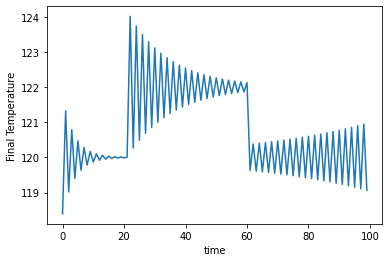

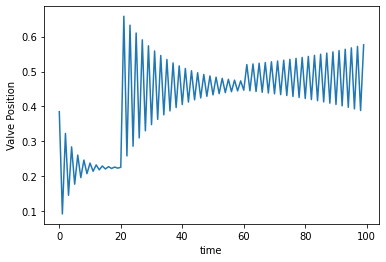

In [6]:
A = System_1(120)
temp = []
valve = []
t = range(100)
for i in t:
    A.run()
    temp.append(A.result.T)
    valve.append(A.first.valve.pos)
    if i == 20:
        # Change is set point
        A.ysp = 122
    if i == 60:
        # Change in set point and steam temp into heat x
        A.ysp = 120
        A.first.next[0].Ts = 96

plt.figure()
plt.plot(t, temp)
plt.xlabel("time")
plt.ylabel("Final Temperature")
plt.figure()
plt.plot(t, valve)
plt.xlabel("time")
plt.ylabel("Valve Position")

<h3> Modification for Noise </h3>

In [6]:
class System_2(System_1):
    def __init__(self, ysp, fluid = None):
        super().__init__(ysp, fluid)
    
    def run_errors(self):
        # A simulation of the system. All changes are instantaneous. Noise has been added.
        # Some parts compound the errors to suggest a degredation in perfomance over time
        dev1 = random.gauss(0, .5)
        dev2 = random.gauss(0, .3)
        dev3 = random.gauss(0, 0.001)
        self.first.fluid.T += dev1
        self.first.fluid.m += dev2
        self.first.valve.pos += dev3
        self.first.split()
        # self.first.fluid.T -= dev1
        # self.first.fluid.m -= dev2
        # self.first.valve.pos -= dev3

        dev1 = random.gauss(0, 0.2)
        dev2 = random.gauss(0, 50)
        self.first.next[0].Ts += dev1
        self.first.next[0].UA += dev2
        self.first.next[0].T_out()
        # self.first.next[0].Ts -= dev1
        # self.first.next[0].UA -= dev2

        self.first.next[1].T_out()

        dev1 = random.gauss(0, 2)
        dev2 = random.gauss(0, 1)
        dev3 = random.gauss(0, 0.03)
        self.fluid.T += dev1
        self.fluid.m += dev2
        self.result.T += dev3
        self.controller.control()
        self.fluid.T -= dev1
        self.fluid.m -= dev2
        self.result.T -= dev3


<h3> Demonstration </h3>

Text(0, 0.5, 'Valve Position')

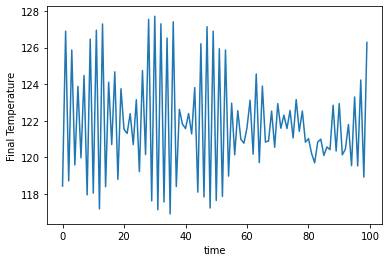

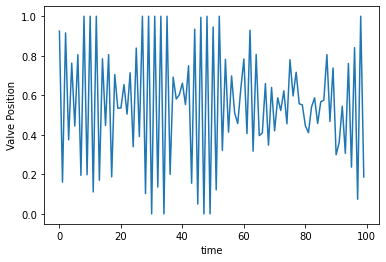

In [7]:
A = System_2(123)
temp = []
valve = []
t = range(100)
for i in t:
    A.run_errors()
    temp.append(A.result.T)
    valve.append(A.first.valve.pos)

plt.figure()
plt.plot(t, temp)
plt.xlabel("time")
plt.ylabel("Final Temperature")
plt.figure()
plt.plot(t, valve)
plt.xlabel("time")
plt.ylabel("Valve Position")